# Training a Neural Network to Embed Car Images

In this notebook, I fine-tune a ResNet18 to produce embeddings from images of cars in a latent space where distance encodes separation in time (a car built in 1996 is far from a 2012 car and close to a 1997 car).

In [15]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision.models import ResNet18_Weights
from torchvision.transforms import GaussianBlur, Compose, Grayscale

from datasets import StanfordCars
from models import ResNet18Embedder
from utils import train_embedding_network_with_triplet_loss
from visualization.visualize_embeddings import plot_umap_reduced_embeddings

We first load the dataset. I'm using an image transformation pipeline that (along with standard normalization used in image preprocessing) sends all images to grayscale and randomly blurs some images. This is to prevent the network from learning any dependencies on pixelation or color when separating cars in the latent space.

In [16]:
image_augmentation = Compose([
    Grayscale(num_output_channels=3),
    ResNet18_Weights.DEFAULT.transforms(),
    GaussianBlur(kernel_size=(17, 11), sigma=(0.1, 3)),
])

ROOT_DIR = './assets'

stanford_cars_train = StanfordCars(root=ROOT_DIR, transform=image_augmentation, split='train', classify_by_year=True)
stanford_cars_test = StanfordCars(root=ROOT_DIR, transform=image_augmentation, split='test', classify_by_year=True)

Now we're ready to initialize and train the model. It will send images of cars from the Stanford Cars dataset to 256-dimensional vectors in a latent space where distance encodes separation in time.

In [23]:
# Initialize hyperparameters.

num_epochs = 10
validate_every = 75
margin = 1
lr = 1e-3
train_pct = 0.9
batch_size = 32
num_workers = 4
embedding_dim = 256

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
model = ResNet18Embedder(embedding_dim)

In [19]:
train_length = int(train_pct * len(stanford_cars_train))
val_length = len(stanford_cars_train) - train_length
stanford_cars_train, stanford_cars_val = random_split(stanford_cars_train, [train_length, val_length])

train_loader = DataLoader(stanford_cars_train, batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
val_loader = DataLoader(stanford_cars_val, batch_size, shuffle=False, num_workers=num_workers, drop_last=True)
test_loader = DataLoader(stanford_cars_test, batch_size, shuffle=False, num_workers=num_workers)

Before training the model, I want to see what kind of embeddings it generates. This will create a useful point of comparison for when the model is done training.

In [21]:
embeddings = []
class_labels = []
num_embeddings_to_generate = len(stanford_cars_test)

model = model.to(device)

model.eval()
with torch.no_grad():

    count = 0
    for batch, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        outputs = model(images)

        embeddings.extend(list(outputs.cpu()))
        class_labels.extend(list(labels))

        count += len(images)

        if count >= num_embeddings_to_generate:
            break

embeddings = np.row_stack(embeddings)
class_labels = np.array(class_labels)

print(embeddings.shape, class_labels.shape)

(8041, 256) (8041,)


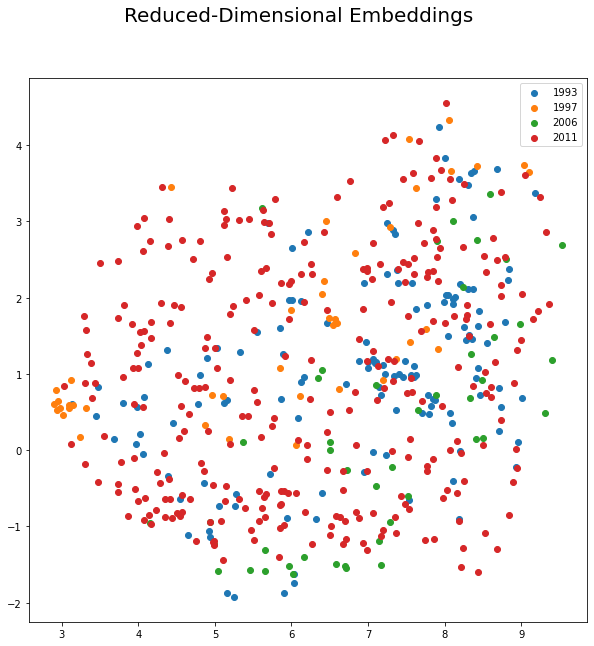

In [22]:
untrained_projections = plot_umap_reduced_embeddings(embeddings, class_labels, classes_to_plot=[1993, 1997, 2006, 2011])

We now train the network.

In [24]:
training_stats = train_embedding_network_with_triplet_loss(model, train_loader, val_loader, num_epochs, lr,
                                      margin, validate_every, checkpoint=True,
                                      save_path="checkpoints/resnet18_embedder_checkpoint.pt")

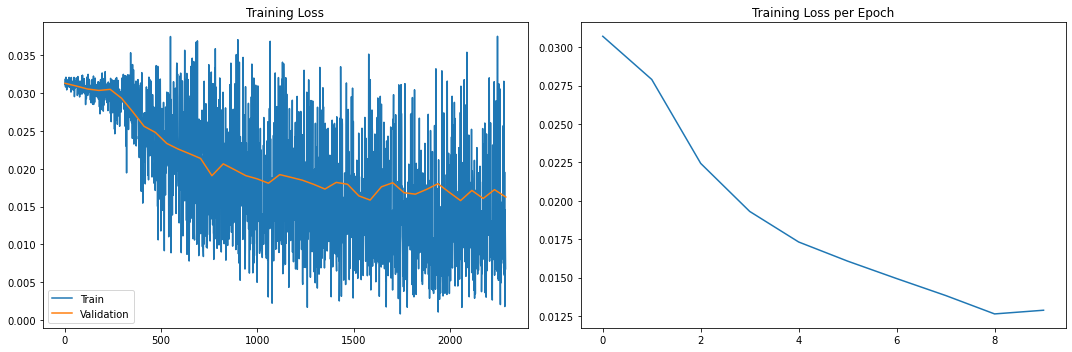

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].set_title("Training Loss")
axs[0].plot(training_stats['train_losses'], label="Train")
axs[0].plot(np.linspace(0, len(training_stats['train_losses']), len(training_stats['val_losses'])), training_stats['val_losses'], label="Validation")
axs[0].legend()

axs[1].set_title("Training Loss per Epoch")
axs[1].plot(training_stats['train_losses_epoch'])

plt.tight_layout()
plt.show()

Now the model is trained, we're ready to see if it's learned meaningful relationships between cars from different eras.

In [26]:
tuned_embeddings = []
class_labels = []

num_embeddings_to_generate = len(stanford_cars_test)

model.eval()
with torch.no_grad():

    count = 0
    for batch, (images, labels) in enumerate(test_loader):
        images = images.cuda()
        outputs = model(images)

        tuned_embeddings.extend(list(outputs.cpu()))
        class_labels.extend(list(labels))

        count += len(images)

        if count >= num_embeddings_to_generate:
            break

tuned_embeddings = np.row_stack(tuned_embeddings)
class_labels = np.array(class_labels)

print(tuned_embeddings.shape, class_labels.shape)

(8041, 256) (8041,)


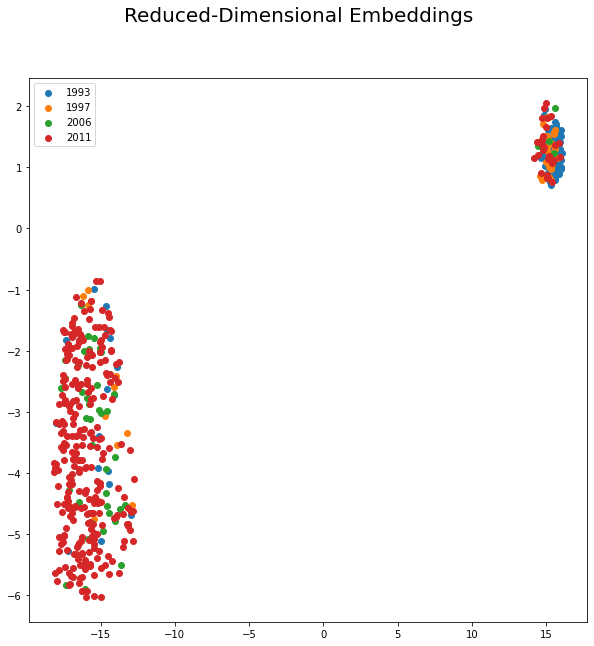

In [27]:
trained_projections = plot_umap_reduced_embeddings(tuned_embeddings, class_labels, classes_to_plot=[1993, 1997, 2006, 2011])

In [51]:
np.save(f"checkpoints/embeddings_{embedding_dim}_blur_grayscale.npy", tuned_embeddings)